In [1]:
import sys
sys.version

In [2]:
# load libraries
import numpy as np
import h5py
import gdal
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# user-defined values

mapped_stems_file = "data/output/mapped_stems_final.shp"

hs_file = "data/hyperspectral/NEON_D13_NIWO_DP3_450000_4432000_reflectance.h5"

site = "NIWO" # this is needed to navigate the h5 tree

## Mapped Stems and Polygons

In [4]:
# read mapped stems shapefile
mapped_stems = gpd.read_file(mapped_stems_file)
mapped_stems.head()

,indvdID,scntfcN,taxonID,geometry
0,NEON.PLA.D13.NIWO.00260,Abies lasiocarpa (Hook.) Nutt. var. lasiocarpa,ABLAL,POINT (450032.8731916947 4433597.509626328)
1,NEON.PLA.D13.NIWO.00262,Picea engelmannii Parry ex Engelm.,PIEN,POINT (450035.6774237959 4433606.070288112)
2,NEON.PLA.D13.NIWO.00463,Picea engelmannii Parry ex Engelm.,PIEN,POINT (450129.0238475716 4433080.988866569)
3,NEON.PLA.D13.NIWO.00477,Picea engelmannii Parry ex Engelm.,PIEN,POINT (450127.4621571384 4433086.713280249)
4,NEON.PLA.D13.NIWO.01023,Pinus contorta Douglas ex Loudon var. latifoli...,PICOL,POINT (453322.405271168 4432450.418917234)


shapefile crs:  {'init': 'epsg:32613'}


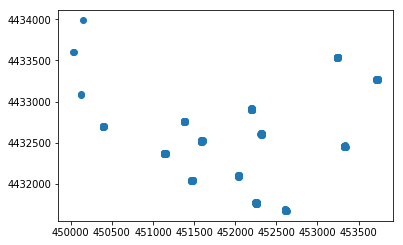

In [29]:
# print some information about the shapefile
print('shapefile crs: ', mapped_stems.crs) 

# quick plot of the stems 
mapped_stems.plot()

In [33]:
# list the column names of the data frame
mapped_stems.dtypes

# add a new column with the geographic extent of each entry
mapped_stems.loc[:,'xMin'] = None

indvdID     object
scntfcN     object
taxonID     object
geometry    object
xMin        object
dtype: object

## Hyperspectral processing

Hyperspectral code from NEON: https://www.neonscience.org/neon-aop-hdf5-py 

In [14]:
# read hyperspectral imagery
f = h5py.File(hs_file,'r') 

In [7]:

def list_dataset(name,node):
    # lists the names of datasets in an hdf5 file
    if isinstance(node, h5py.Dataset):
        print(name)

#f.visititems(list_dataset)


def ls_dataset(name,node):
    # displays the name, shape, and type of datasets in hdf5 file
    if isinstance(node, h5py.Dataset):
        print(node)

#f.visititems(ls_dataset)

In [12]:
# extract the reflectance data 
refl = f['NIWO']['Reflectance']
refl_array = refl['Reflectance_Data']
refl_shape = refl_array.shape
print(refl_array)
print(refl_shape)

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">
(1000, 1000, 426)


In [9]:
# extract the reflectance metadata
wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
print(wavelengths)
# print(wavelengths.value)

# Display min & max wavelengths
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

<HDF5 dataset "Wavelength": shape (426,), type "<f4">
min wavelength: 381.273 nm
max wavelength: 2509.728 nm


In [19]:
#Extract relevant metadata 

# Get the coordinate system map info
mapInfo = refl['Metadata']['Coordinate_System']['Map_Info']
print('Map Info:\n', mapInfo.value)

mapInfo_string = str(mapInfo.value) #convert to string
mapInfo_split = mapInfo_string.split(",") #split the strings using the separator "," 
print(mapInfo_split)

#Extract the resolution & convert to floating decimal number
res = float(mapInfo_split[5]),float(mapInfo_split[6])
print('Resolution:',res)

#Extract the upper left-hand corner coordinates from mapInfo
xMin = float(mapInfo_split[3]) 
yMax = float(mapInfo_split[4])
#Calculate the xMax and yMin values from the dimensions
#xMax = left corner + (# of columns * resolution)
xMax = xMin + (refl_shape[1]*res[0])
yMin = yMax - (refl_shape[0]*res[1]) 

# print('xMin:',xMin) ; print('xMax:',xMax) 
# print('yMin:',yMin) ; print('yMax:',yMax) 
ext = (xMin, xMax, yMin, yMax)
print('ext:',ext)

#Can also create a dictionary of extent:
extDict = {}
extDict['xMin'] = xMin
extDict['xMax'] = xMax
extDict['yMin'] = yMin
extDict['yMax'] = yMax
print('extDict:',extDict)

Map Info:
 b'UTM,  1.000,  1.000,       450000.00,       4433000.0,       1.0000000,       1.0000000,  13,  North,  WGS-84,  units=Meters, 0'
["b'UTM", '  1.000', '  1.000', '       450000.00', '       4433000.0', '       1.0000000', '       1.0000000', '  13', '  North', '  WGS-84', '  units=Meters', " 0'"]
Resolution: (1.0, 1.0)
ext: (450000.0, 451000.0, 4432000.0, 4433000.0)
extDict: {'yMin': 4432000.0, 'xMin': 450000.0, 'yMax': 4433000.0, 'xMax': 451000.0}


Extract a single band from the array

b56 type: <class 'numpy.ndarray'>
b56 shape: (1000, 1000)
Band 56 Reflectance:
 [[1363. 1449. 1082. ...  498.  598.  657.]
 [1170. 1135. 1205. ...  537.  586.  601.]
 [1307. 1190. 1292. ...  687.  635.  558.]
 ...
 [  14.   10.   56. ...  437.  857.  853.]
 [  35.  171.   60. ...  651.  721.  900.]
 [  61.  104.   68. ...  790.  743.  774.]]


Text(0,0.5,'Frequency')

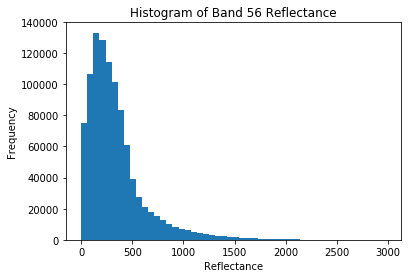

In [20]:
b56 = refl_array[:,:,55].astype(np.float)
print('b56 type:',type(b56))
print('b56 shape:',b56.shape)
print('Band 56 Reflectance:\n',b56)
plt.hist(b56.flatten(),50);
plt.title('Histogram of Band 56 Reflectance')
plt.xlabel('Reflectance'); plt.ylabel('Frequency')

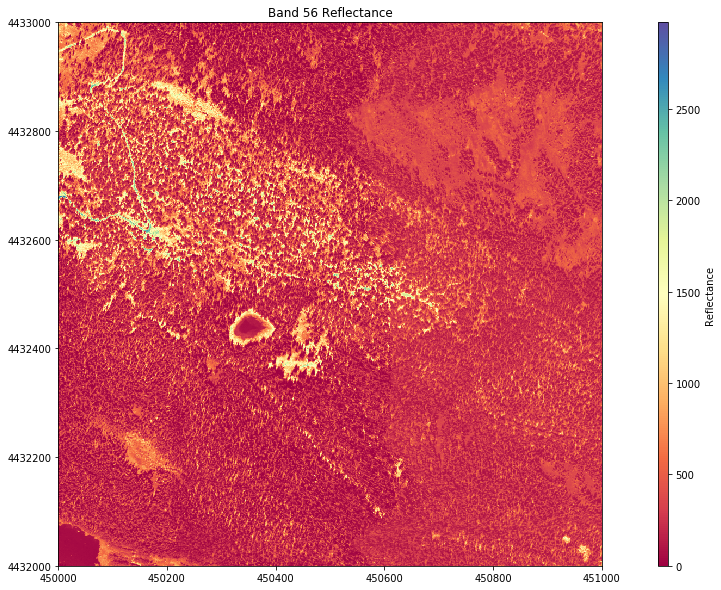

In [26]:
hs_fig = plt.figure(figsize=(20,10))
hs_plot = plt.imshow(b56,extent=ext,cmap='Spectral') 
cbar = plt.colorbar(hs_plot,aspect=50); cbar.set_label('Reflectance')
plt.title('Band 56 Reflectance'); #ax = plt.gca(); 
ax1.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
rotatexlabels = plt.setp(ax1.get_xticklabels(),rotation=270) #rotate x tick labels 90 degree

In [ ]:
# filter the stems for those within the boundary of the current HS tile 

easting_list = [extDict['xMin'], extDict['xMax'], extDict['xMax'], extDict['xMin'], extDict['xMin']]
northing_list = [extDict['yMin'], extDict['yMin'], extDict['yMax'], extDict['yMax'], extDict['yMin']]

tile_boundary = geopandas.GeoDataFrame()
stems_in_tile = mapped_stems[mapped_stems.geometry.within()]



In [34]:
extDict['xMin']


450000.0